# Phase 5: Modeling & Hyperparameter Tuning

**Dataset**: AG News (4 classes — World, Sports, Business, Sci/Tech)  
**Input**: Pre-built TF-IDF sparse matrices from Phase 4  
**Goal**: Train baseline classifiers, tune the best one, and persist the winner.

| Step | Description |
|------|-------------|
| 1 | Load feature matrices |
| 2 | Train & compare baselines (LR, SGD, RF, XGBoost) |
| 3 | Hyperparameter tuning (RandomizedSearchCV) |
| 4 | Evaluation: confusion matrix + per-class F1 |
| 5 | Save best model |

## 0 · Imports

In [1]:
import numpy as np
import scipy.sparse as sp
import joblib
import time
import warnings
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score,
    classification_report, confusion_matrix
)
from scipy.stats import loguniform, randint

warnings.filterwarnings('ignore')

# ── Paths ────────────────────────────────────────────────────────────────────
ROOT        = os.path.abspath(os.path.join(os.getcwd(), '..'))
PROCESSED   = os.path.join(ROOT, 'data', 'processed')
MODELS_DIR  = os.path.join(ROOT, 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

CLASS_NAMES = ['World', 'Sports', 'Business', 'Sci/Tech']
print('ROOT:', ROOT)

ROOT: c:\Users\My Device\Desktop\News-Category-Classification-E


## 1 · Load Feature Matrices

In [2]:
X_train = sp.load_npz(os.path.join(PROCESSED, 'X_train.npz'))
X_test  = sp.load_npz(os.path.join(PROCESSED, 'X_test.npz'))
y_train = np.load(os.path.join(PROCESSED, 'y_train.npy'))
y_test  = np.load(os.path.join(PROCESSED, 'y_test.npy'))

# XGBoost requires 0-indexed labels [0, 1, 2, 3] instead of [1, 2, 3, 4]
if y_train.min() == 1:
    y_train = y_train - 1
    y_test  = y_test - 1

print(f'X_train : {X_train.shape}  |  y_train : {y_train.shape}')
print(f'X_test  : {X_test.shape}   |  y_test  : {y_test.shape}')
print(f'Classes : {np.unique(y_train)}')

X_train : (120000, 50000)  |  y_train : (120000,)
X_test  : (7600, 50000)   |  y_test  : (7600,)
Classes : [0 1 2 3]


## 2 · Baseline Models

We train classifiers and record **accuracy** and **macro-F1**.

In [3]:
def train_and_evaluate(name, model, X_tr, y_tr, X_te, y_te):
    """Fit model, evaluate on test set, return metrics dict."""
    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    y_pred = model.predict(X_te)
    acc    = accuracy_score(y_te, y_pred)
    f1     = f1_score(y_te, y_pred, average='macro')

    print(f'[{name}]  Acc={acc:.4f}  Macro-F1={f1:.4f}  ({train_time:.1f}s)')
    return {'Model': name, 'Accuracy': acc, 'Macro-F1': f1,
            'Train Time (s)': round(train_time, 1), '_model': model, '_pred': y_pred}

In [4]:
baselines = [
    ('Logistic Regression',
     LogisticRegression(C=5, max_iter=1000, solver='lbfgs', n_jobs=-1)),

    ('SGD (Linear SVM)',
     SGDClassifier(loss='modified_huber', max_iter=100,
                   random_state=42, n_jobs=-1)),

    ('Random Forest',
     RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)),

    ('XGBoost',
     XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, 
                   random_state=42, n_jobs=-1, eval_metric='mlogloss'))
]

results = []
for name, model in baselines:
    res = train_and_evaluate(name, model, X_train, y_train, X_test, y_test)
    results.append(res)

[Logistic Regression]  Acc=0.9045  Macro-F1=0.9044  (40.4s)
[SGD (Linear SVM)]  Acc=0.9061  Macro-F1=0.9058  (1.0s)
[Random Forest]  Acc=0.8838  Macro-F1=0.8834  (845.0s)
[XGBoost]  Acc=0.8278  Macro-F1=0.8287  (867.9s)


In [5]:
# ── Comparison table ─────────────────────────────────────────────────────────
df_results = pd.DataFrame([
    {k: v for k, v in r.items() if not k.startswith('_')}
    for r in results
]).set_index('Model')

df_results = df_results.sort_values('Macro-F1', ascending=False)
df_results.style.highlight_max(subset=['Accuracy', 'Macro-F1'], color='#c6efce')

,Accuracy,Macro-F1,Train Time (s)
Model,,,
SGD (Linear SVM),0.906053,0.905827,1.000000
Logistic Regression,0.904474,0.904380,40.400000
Random Forest,0.883816,0.883384,845.000000
XGBoost,0.827763,0.828691,867.900000


## 3 · Hyperparameter Tuning

We tune the **best-performing baseline** using `RandomizedSearchCV` with 5-fold stratified CV.

In [6]:
# Pick best baseline by Macro-F1
best_baseline = max(results, key=lambda r: r['Macro-F1'])
print(f"Best baseline: {best_baseline['Model']}  (Macro-F1={best_baseline['Macro-F1']:.4f})")
print('→ Running RandomizedSearchCV ...')

Best baseline: SGD (Linear SVM)  (Macro-F1=0.9058)
→ Running RandomizedSearchCV ...


In [7]:
# ── Param grids keyed by model name ──────────────────────────────────────────
PARAM_GRIDS = {
    'Logistic Regression': {
        'C': loguniform(1e-2, 1e2),
        'max_iter': [500, 1000, 2000],
    },
    'SGD (Linear SVM)': {
        'alpha': loguniform(1e-5, 1e-1),
        'max_iter': [100, 200, 500],
        'loss': ['modified_huber', 'hinge'],
    },
    'Random Forest': {
        'n_estimators': randint(100, 500),
        'max_depth': [None, 20, 40],
        'min_samples_split': randint(2, 10),
    },
    'XGBoost': {
        'n_estimators': randint(100, 500),
        'learning_rate': loguniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'subsample': [0.7, 0.8, 0.9],
    }
}

model_name  = best_baseline['Model']
base_model  = best_baseline['_model']
param_dist  = PARAM_GRIDS[model_name]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=base_model.__class__(**{
        k: v for k, v in base_model.get_params().items()
    }),
    param_distributions=param_dist,
    n_iter=15,  # Reduced iterations for speed with XGBoost
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

t0 = time.time()
search.fit(X_train, y_train)
print(f'\nSearch done in {time.time()-t0:.1f}s')
print('Best params :', search.best_params_)
print('Best CV F1  :', round(search.best_score_, 4))

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Search done in 68.4s
Best params : {'alpha': np.float64(1.2087541473056957e-05), 'loss': 'hinge', 'max_iter': 200}
Best CV F1  : 0.9096


In [8]:
# ── Evaluate tuned model on held-out test set ─────────────────────────────────
tuned_model = search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)

tuned_acc = accuracy_score(y_test, y_pred_tuned)
tuned_f1  = f1_score(y_test, y_pred_tuned, average='macro')

print(f'Tuned {model_name}  →  Acc={tuned_acc:.4f}  Macro-F1={tuned_f1:.4f}')
print()
print(classification_report(y_test, y_pred_tuned, target_names=CLASS_NAMES))

Tuned SGD (Linear SVM)  →  Acc=0.9109  Macro-F1=0.9108

              precision    recall  f1-score   support

       World       0.94      0.89      0.91      1900
      Sports       0.95      0.98      0.96      1900
    Business       0.88      0.87      0.88      1900
    Sci/Tech       0.88      0.90      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



## 4 · Evaluation Visualizations

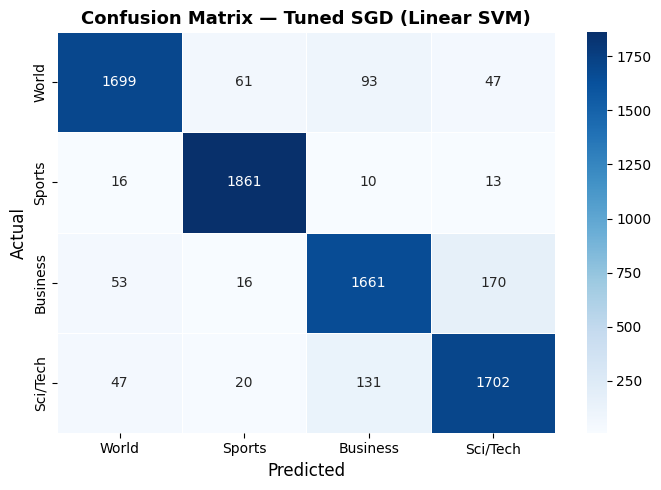

Saved → models/confusion_matrix.png


In [9]:
# ── 4a. Confusion Matrix ──────────────────────────────────────────────────────
cm = confusion_matrix(y_test, y_pred_tuned)

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
    linewidths=0.5, ax=ax
)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix — Tuned {model_name}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'confusion_matrix.png'), dpi=150)
plt.show()
print('Saved → models/confusion_matrix.png')

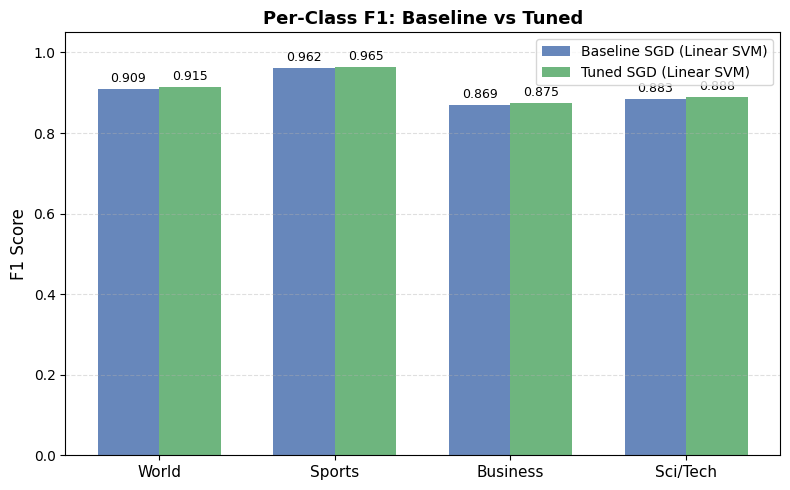

Saved → models/per_class_f1.png


In [10]:
# ── 4b. Per-class F1 comparison (baseline vs tuned) ───────────────────────────
f1_baseline = f1_score(y_test, best_baseline['_pred'], average=None)
f1_tuned    = f1_score(y_test, y_pred_tuned, average=None)

x = np.arange(len(CLASS_NAMES))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, f1_baseline, width, label=f'Baseline {model_name}',
               color='#4C72B0', alpha=0.85)
bars2 = ax.bar(x + width/2, f1_tuned,    width, label=f'Tuned {model_name}',
               color='#55A868', alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, fontsize=11)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_ylim(0, 1.05)
ax.set_title('Per-Class F1: Baseline vs Tuned', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.bar_label(bars1, fmt='%.3f', padding=3, fontsize=9)
ax.bar_label(bars2, fmt='%.3f', padding=3, fontsize=9)
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'per_class_f1.png'), dpi=150)
plt.show()
print('Saved → models/per_class_f1.png')

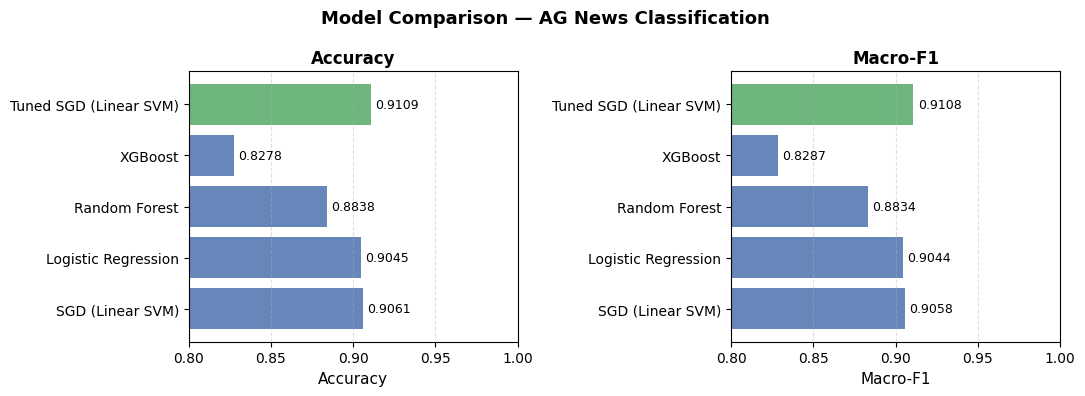

Saved → models/model_comparison.png


In [11]:
# ── 4c. Model comparison bar chart ───────────────────────────────────────────
all_models = df_results.copy()
all_models.loc[f'Tuned {model_name}'] = {
    'Accuracy': tuned_acc,
    'Macro-F1': tuned_f1,
    'Train Time (s)': '—'
}
all_models['Accuracy'] = all_models['Accuracy'].astype(float)
all_models['Macro-F1'] = all_models['Macro-F1'].astype(float)

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
for ax, metric in zip(axes, ['Accuracy', 'Macro-F1']):
    vals   = all_models[metric]
    colors = ['#55A868' if i == vals.idxmax() else '#4C72B0' for i in vals.index]
    bars   = ax.barh(vals.index, vals, color=colors, alpha=0.85)
    ax.set_xlim(0.8, 1.0)
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.bar_label(bars, fmt='%.4f', padding=3, fontsize=9)
    ax.grid(axis='x', linestyle='--', alpha=0.4)

plt.suptitle('Model Comparison — AG News Classification', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'model_comparison.png'), dpi=150)
plt.show()
print('Saved → models/model_comparison.png')

## 5 · Save Best Model

In [12]:
best_model_path = os.path.join(MODELS_DIR, 'best_model.joblib')
joblib.dump(tuned_model, best_model_path)
print(f'✓ Best model saved → {best_model_path}')
print(f'  Model type : {type(tuned_model).__name__}')
print(f'  Accuracy   : {tuned_acc:.4f}')
print(f'  Macro-F1   : {tuned_f1:.4f}')

✓ Best model saved → c:\Users\My Device\Desktop\News-Category-Classification-E\models\best_model.joblib
  Model type : SGDClassifier
  Accuracy   : 0.9109
  Macro-F1   : 0.9108


## 6 · Summary

> Run all cells to populate results table.

**Artifacts produced:**
- `models/best_model.joblib` — serialized best estimator
- `models/confusion_matrix.png`
- `models/per_class_f1.png`
- `models/model_comparison.png`